In [6]:
# Cell 1: imports and simple helper

import cv2
import numpy as np
from pathlib import Path

def describe_image(img, name="image"):
    """
    Print basic info about an image (for debugging).
    - img: numpy array (image)
    - name: label printed in the logs
    """
    if img is None:
        print(f"[ERROR] {name} is None (image not loaded correctly)")
        return
    h, w = img.shape[:2]
    print(f"[INFO] {name}: shape={img.shape}, height={h}, width={w}, dtype={img.dtype}")


In [7]:
# Cell 2: fixed ROI cropping (for ECG reports with the same layout)

def fixed_roi_crop(gray_img):
    """
    Crop a fixed region of interest (ROI) from the ECG report.

    The cropping ratios (top_frac, bottom_frac, etc.) are fractions of the
    total image height/width and must be tuned to your template.

    Parameters
    ----------
    gray_img : 2D numpy array
        Grayscale ECG report image.

    Returns
    -------
    roi : 2D numpy array
        Cropped region containing mainly the ECG traces.
    """

    h, w = gray_img.shape[:2]

    # Fractions of height/width to keep (adjust for your template)
    top_frac = 0.18     # remove header with patient info
    bottom_frac = 0.92  # remove bottom margin
    left_frac = 0.03    # remove left border
    right_frac = 0.98   # remove right border

    # Convert fractions to pixel indices
    top = int(top_frac * h)
    bottom = int(bottom_frac * h)
    left = int(left_frac * w)
    right = int(right_frac * w)

    # Crop the ROI
    roi = gray_img[top:bottom, left:right]

    return roi


In [8]:
# Cell 3: simple grayscale -> crop pipeline (no denoise / resize)

def crop_ecg_only(
    input_path: str,
    output_path: str,
    verbose: bool = False,
):
    """
    Minimal preprocessing: load image, convert to grayscale, crop the ROI,
    and save the cropped region as-is (no resizing or filtering).
    """

    img = cv2.imread(str(input_path))
    if img is None:
        raise FileNotFoundError(f"Cannot read image at {input_path}")

    if verbose:
        describe_image(img, "original")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if verbose:
        describe_image(gray, "gray")

    roi = fixed_roi_crop(gray)
    if verbose:
        print("[INFO] Using FIXED ROI cropping")
        describe_image(roi, "roi_cropped")

    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    cv2.imwrite(str(output_path), roi)
    if verbose:
        print(f"[INFO] Saved cropped ECG to: {output_path}")


In [9]:
# Cell 4: batch cropping helper for entire folders

from typing import Iterable

def batch_crop_ecg(input_dir, output_dir, verbose: bool = False):
    """Apply crop_ecg_only to every image under input_dir."""
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    if not input_dir.exists():
        raise FileNotFoundError(f"Input directory not found: {input_dir}")

    valid_ext = {'.jpg', '.jpeg', '.png', '.bmp'}
    image_paths = sorted(
        p for p in input_dir.rglob('*') if p.suffix.lower() in valid_ext
    )

    if not image_paths:
        raise FileNotFoundError(
            f"No image files (jpg/png/bmp) found under {input_dir}"
        )

    for img_path in image_paths:
        rel = img_path.relative_to(input_dir)
        out_path = output_dir / rel
        crop_ecg_only(img_path, out_path, verbose=verbose)
        print(f"[OK] {img_path} -> {out_path}")


In [10]:
# Cell 5: apply crop-only preprocessing to Dataset/Dataset1

DATASET_DIR = Path('../Datasets')
SOURCE_FOLDER = DATASET_DIR / 'Dataset'
OUTPUT_FOLDER = DATASET_DIR / 'Dataset_cropped'

batch_crop_ecg(SOURCE_FOLDER, OUTPUT_FOLDER, verbose=False)
print(f"[DONE] Cropped images saved under: {OUTPUT_FOLDER}")


[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(1).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patients\MI(1).jpg
[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(10).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patients\MI(10).jpg
[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(100).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patients\MI(100).jpg
[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(101).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patients\MI(101).jpg
[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(102).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patients\MI(102).jpg
[OK] ..\Datasets\Dataset\ECG Images of Myocardial Infarction Patients\MI(103).jpg -> ..\Datasets\Dataset_cropped\ECG Images of Myocardial Infarction Patient

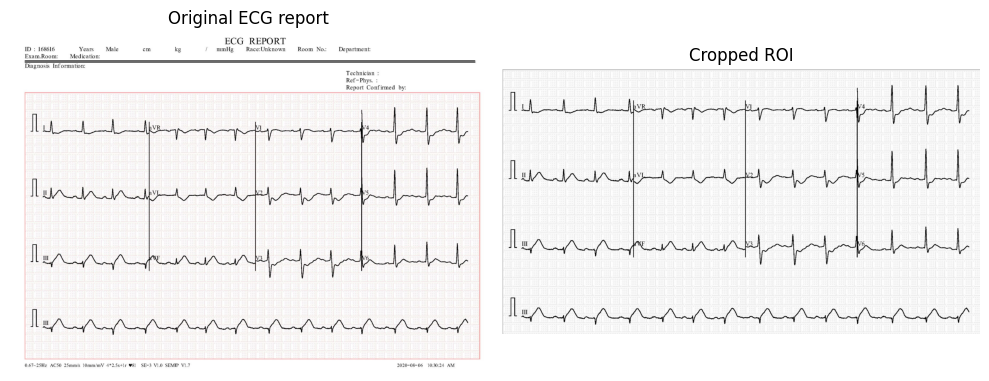

In [11]:
# Cell 6 (optional): display original vs cropped sample

import matplotlib.pyplot as plt

# Pick the first available sample inside SOURCE_FOLDER
sample_input = next(SOURCE_FOLDER.rglob('*.jpg'))
sample_output = OUTPUT_FOLDER / sample_input.relative_to(SOURCE_FOLDER)

orig = cv2.imread(str(sample_input))
orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

cropped = cv2.imread(str(sample_output), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original ECG report')
plt.imshow(orig_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Cropped ROI')
plt.imshow(cropped, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
